In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import math
import optuna
import time
from scipy.integrate import odeint
from sklearn import preprocessing

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# EarlyStopping function

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [3]:
# Tells whether the model is running on CPU or GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('using GPU:', torch.cuda.get_device_name()) if torch.cuda.is_available() else 'using cpu'

'using cpu'

# DEFINE PARAMETERS

In [4]:
# define constant parameters

R = (6.4*10e-3)/2 # Tubular radius, units: m
qp_480 = 1.3 * 10e-4 # Photon flux, units: moles photons · m-2 · s-1
Vr = 4.78 * 10e-6 # Reactor volume, units: m3
CB = 0.4 # Concentartion of reactant B, units: M

# Calculate photon flux at different power ratings

# 240 W
qp_240 = qp_480*240/480

#120 W
qp_120 = qp_480*120/480

In [5]:
# Regressed parameters

phi_n = 3.64157355e-01 # Quantum yield, units: mole/Einstien
mpc = 1.00637223e-01 # photon absorption by photocatalyst
ka = 9.75555522e-01 # Napierian molar absorption coefficient of specis A, units: m2/mol 
kc = 1.00000000e+02 # Napierian molar absorption coefficient of specis C, units: m2/mol 
k1 = 1.81787184e+00 # rate constant for formation of species C
k2 =  1.00346260e-02 # rate constant for formation of species E

# LOAD DATA

In [7]:
Y1_list = []
Y2_list = []
Y3_list = []
Input_list = []
for i in range(1,10):
    name = "Sheet" + str(i)
    print(name)
    raw_input = pd.read_excel("Updated_photochemical_Experiment.xlsx",name)
    X=raw_input.values.astype(np.float64)
    X1 = X[:,2]
    Y1 = X[:,10]
    Y2 = X[:,11]
    Y3 = X[:,9]
    
    Y1_list.append(Y1)
    Y2_list.append(Y2)
    Y3_list.append(Y3)
    
    Input_list.append([X[0,0],X[0,1],Y1[0],Y2[0],Y3[0]])  #Y1,Y2,Y3 ==1,0,0


Sheet1
Sheet2
Sheet3
Sheet4
Sheet5
Sheet6
Sheet7
Sheet8
Sheet9


In [8]:
print(Input_list)
X_input = np.array(Input_list).reshape(-1,1,5)
RNN_input = X_input.repeat(36, axis=1)  # to keep consensus with the shape for RNN_output, since the output variable is collected 100(0.01/1e-4) times for each RNN_input
print("RNN_input shape is {}".format(RNN_input.shape))

[[0.2, 480.0, 1.0, 0.0, 0.0], [0.2, 240.0, 1.0, 0.0, 0.0], [0.2, 120.0, 1.0, 0.0, 0.0], [0.3, 480.0, 1.0, 0.0, 0.0], [0.3, 240.0, 1.0, 0.0, 0.0], [0.3, 120.0, 1.0, 0.0, 0.0], [0.4, 480.0, 1.0, 0.0, 0.0], [0.4, 240.0, 1.0, 0.0, 0.0], [0.4, 120.0, 1.0, 0.0, 0.0]]
RNN_input shape is (9, 36, 5)


In [9]:
X_input = np.array(Input_list).reshape(-1,1,5)
RNN_input = X_input.repeat(36, axis=1)  # to keep consensus with the shape for RNN_output
print("RNN_input shape is {}".format(RNN_input.shape))

RNN_input shape is (9, 36, 5)


In [10]:
Y1_output = np.array(Y1_list)
Y1_output = Y1_output.reshape(-1, 36, 1)
Y2_output = np.array(Y2_list)
Y2_output = Y2_output.reshape(-1, 36, 1)
Y3_output = np.array(Y3_list)
Y3_output = Y3_output.reshape(-1, 36, 1)
RNN_output = np.concatenate((Y1_output, Y2_output, Y3_output), axis=2)
print("RNN_output shape is {}".format(RNN_output.shape))  # output shape: number of samples x timestep x variables

RNN_output shape is (9, 36, 3)


In [11]:
# Normalization

scaler_X = preprocessing.StandardScaler().fit(RNN_input.reshape(-1, 5))
scaler_y = preprocessing.StandardScaler().fit(RNN_output.reshape(-1, 3))

print(scaler_X.mean_)
print(scaler_X.var_)
print(scaler_y.mean_)
print(scaler_y.var_)

RNN_input = scaler_X.transform(RNN_input.reshape(-1, 5)).reshape(-1,36,5)
RNN_output = scaler_y.transform(RNN_output.reshape(-1, 3)).reshape(-1,36,3)

mean_y = torch.from_numpy(scaler_y.mean_).float()
std_y = torch.from_numpy(np.sqrt(scaler_y.var_)).float()

[  0.3 280.    1.    0.    0. ]
[6.66666667e-03 2.24000000e+04 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
[0.29611469 0.69253774 0.01134757]
[2.33151041e-02 2.22718238e-02 1.73960109e-05]


In [12]:
torch.save(mean_y,'mean_y.pt')
torch.save(std_y,'std_y.pt')
np.save('mean_X.npy',scaler_X.mean_)
np.save('std_X.npy',np.sqrt(scaler_X.var_))

In [13]:
# split into train and test sets
x_train = RNN_input[:5,:,:]
x_test  = RNN_input[7:,:,:]
x_val = RNN_input[5:7,:,:]
y_train = RNN_output[:5,:,:]
y_test =  RNN_output[7:,:,:]
y_val = RNN_output[5:7,:,:]

In [14]:
############################# Split Train, Test, and Validation dataset ##################################

#X_train, x_test, Y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.2, random_state=42)

#x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42) 

print(f"X_train shape is {x_train.shape}, X_val shape is {x_val.shape}, X_test shape is {x_test.shape}")
print(f"y_train shape is {y_train.shape}, y_val shape is {y_val.shape}, y_test shape is {y_test.shape}")

X_train shape is (5, 36, 5), X_val shape is (2, 36, 5), X_test shape is (2, 36, 5)
y_train shape is (5, 36, 3), y_val shape is (2, 36, 3), y_test shape is (2, 36, 3)


In [15]:
mean_X = np.load('mean_X.npy')
std_X = np.load('std_X.npy')
mean_y = torch.load('mean_y.pt')
std_y=torch.load('std_y.pt')

# COLLOCATION POINTS

In [16]:
# generating collocation points 
# u1 = Reactant feed concentration, u2 = Power rating

u1_physics_list = np.linspace(0.2,0.3, 20)
u2_physics_list = np.linspace(120,480, 20) 

In [17]:
u1_physics_input = list()
u2_physics_input = list()
Y_1_list = []
Y_2_list = []
Y_3_list = []

for num_id, u1 in enumerate(u1_physics_list):
    print(f"{num_id + 1} out of {u1_physics_list.shape[0]}")    #just to count and keep track
    CBi = u1 
    
    for u2 in u2_physics_list:
        F = u2 
        
        u1_physics_input.append(u1)
        u2_physics_input.append(u2)
        
        Y_1 = 1
        Y_2 = 0
        Y_3 = 0
    
        Y_1_list.append(Y_1)
        Y_2_list.append(Y_2)
        Y_3_list.append(Y_3)

1 out of 20
2 out of 20
3 out of 20
4 out of 20
5 out of 20
6 out of 20
7 out of 20
8 out of 20
9 out of 20
10 out of 20
11 out of 20
12 out of 20
13 out of 20
14 out of 20
15 out of 20
16 out of 20
17 out of 20
18 out of 20
19 out of 20
20 out of 20


In [18]:
# collate input 

u1_physics_input = np.array(u1_physics_input)
u1_physics_input = u1_physics_input.reshape(-1,1,1)


u2_physics_input = np.array(u2_physics_input)
u2_physics_input = u2_physics_input.reshape(-1,1,1)


Y_1_list = np.array(Y_1_list)
Y_1_list = Y_1_list.reshape(-1,1,1)

Y_2_list = np.array(Y_2_list)
Y_2_list = Y_2_list.reshape(-1,1,1)

Y_3_list = np.array(Y_3_list)
Y_3_list = Y_3_list.reshape(-1,1,1)



RNN_physics_input_tempc = np.concatenate((u1_physics_input, u2_physics_input, Y_1_list, Y_2_list, Y_3_list), axis=2)

"""
    the input to RNN is in the shape [number of samples x timestep x variables], and the input variables are same for every
    time step
"""

RNN_physics_input_tempc = RNN_physics_input_tempc.repeat(36, axis=1)
print("RNN_physics_input_temp shape is {}".format(RNN_physics_input_tempc.shape))

RNN_physics_input_temp shape is (400, 36, 5)


In [19]:
RNN_physics_input_tempc = scaler_X.transform(RNN_physics_input_tempc.reshape(-1, 5)).reshape(-1,36,5)

In [20]:
#X_collocation_train, X_collocation_val
X_collocation_train = RNN_physics_input_tempc[80:,:,:]
X_collocation_val = RNN_physics_input_tempc[:80,:,:]

In [21]:
print(f'X_collocation_train shape is: {X_collocation_train.shape}')
print(f'X_collocation_val shape is: {X_collocation_val.shape}')

X_collocation_train shape is: (320, 36, 5)
X_collocation_val shape is: (80, 36, 5)


# TRANSFORMING DATA FOR TRAINING

In [22]:
X_collocation_train = torch.from_numpy(X_collocation_train).float()
X_collocation_val = torch.from_numpy(X_collocation_val).float()

In [23]:
x_train = torch.from_numpy(x_train).float()
x_val = torch.from_numpy(x_val).float()
x_test = torch.from_numpy(x_test).float()

In [24]:
y_train = torch.from_numpy(y_train).float()
y_val = torch.from_numpy(y_val).float()
y_test = torch.from_numpy(y_test).float()

In [25]:
dataset_physics_train = TensorDataset(x_train, y_train)
dataloader_physics_train = DataLoader(dataset_physics_train, batch_size=10800, shuffle=True)

dataset_physics_val = TensorDataset(x_val, y_val)
dataloader_physics_val = DataLoader(dataset_physics_val, batch_size=10800, shuffle=True)

dataset_physics_test = TensorDataset(x_test, y_test)
dataloader_physics_test = DataLoader(dataset_physics_test, batch_size=1, shuffle=False)

# DEFINING RNN

In [26]:
class RNN(nn.Module):
    "Defines a RNN network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(RNN, self).__init__()
        self.layers = N_LAYERS
        
        if isinstance(N_HIDDEN, list):
            self.rnn = nn.LSTM(N_INPUT, 
                                N_HIDDEN[0], 
                                batch_first=True)
            
            self.rnn1 = nn.ModuleList(
                [nn.LSTM(N_HIDDEN[i], 
                        N_HIDDEN[i+1],
                       batch_first=True) for i in range(N_LAYERS - 1)]
            )
            
            self.output_layer = nn.Linear(N_HIDDEN[-1], N_OUTPUT)
            
            self.list_flag = True
            
        else:
            self.rnn = nn.LSTM(N_INPUT, 
                                N_HIDDEN,
                                N_LAYERS,
                                batch_first=True,
                                dropout=0.1)
            
            self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)
            
            self.list_flag = False                                             
        
    def forward(self, x):
        x, _ = self.rnn(x)
        
        if self.list_flag:
            for i in range(self.layers - 1):
                x, _ = self.rnn1[i](x)
                
        x = self.output_layer(x)
        return x

In [27]:
t_step = 1

# PHYSICS INFORMED RNN

In [39]:
def train_model(model, patience, n_epochs, X_collocation_train, X_collocation_val):

    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
 
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3, weight_decay=1e-5) # Adam optimizer
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=50, verbose=True)

    for epoch in range(1,n_epochs+1):
        
        epoch_mse = []
        
        ###################
        # train the model #
        ###################
        model.train() # prep model for training 

        for id_batch, (x_batch, y_batch) in enumerate(dataloader_physics_train):
            x_batch, y_batch = x_batch[0].to(device), y_batch[0].to(device)
            optimizer.zero_grad()

            NN_outputd = model(x_batch) # the predicted values x̃ are obtained by passing the input vector to the PIRNN model

            # Data driven loss term
            loss1 = torch.mean((NN_outputd[ :, :] - y_batch[ :, :])**2)  # use mean squared error
            
            # # Use Collocation points to compute physics based loss
            
            X_collocation_train = X_collocation_train.to(device) 
            NN_output = model(X_collocation_train)

            # Compute the physics-driven loss term
            CB = 0.4
            CAo = X_collocation_train[:, :, 0] * std_X[0] + mean_X[0]
            qp_1 = X_collocation_train[:,  :, 1] * std_X[1] + mean_X[1]
            qp_2 = qp_1.detach().numpy()
            qp = 1.3*10e-4*(qp_2)/480
            qp = torch.from_numpy(qp) 

            NN_output = NN_output * std_y.to(device) + mean_y.to(device)

            dCA_first = (NN_output[:,  1:2, 0] - X_collocation_train[:, 0:1, 2]) / (2*t_step)
            dCA_center = (NN_output[:,  2:, 0] - NN_output[:, :-2, 0]) / (2 * t_step)
            dCA_last = (NN_output[ :, -1:, 0] - NN_output[ :, -2:-1, 0]) / (t_step)
              
            dCC_first = (NN_output[:,  1:2, 1] - X_collocation_train[:, 0:1, 3]) / (2*t_step)
            dCC_center = (NN_output[:,  2:, 1] - NN_output[:,  :-2, 1]) / (2 * t_step)
            dCC_last = (NN_output[ :, -1:, 1] - NN_output[ :, -2:-1, 1]) / (t_step)
            
            dCE_first = (NN_output[ :, 1:2, 2] - X_collocation_train[:, 0:1, 4]) / (2*t_step)
            dCE_center = (NN_output[:,  2:, 2] - NN_output[:,  :-2, 2]) / (2 * t_step)
            dCE_last = (NN_output[:,  -1:, 2] - NN_output[ :, -2:-1, 2]) / (t_step)

            dCA = torch.cat((dCA_first, dCA_center, dCA_last), 1)
            dCC = torch.cat((dCC_first, dCC_center, dCC_last), 1)
            dCE = torch.cat((dCE_first, dCE_center, dCE_last), 1)

            ### Definition of the physics-based loss ###
            
            lossCA = dCA - ((phi_n/CAo)*(qp/Vr)*(ka*NN_output[:,  :, 0]*CAo/(mpc+ka*NN_output[ :, :, 0]*CAo+kc*NN_output[ :, :, 1]*CAo))
                            *(1-torch.exp(-(mpc+ka*NN_output[:,  :, 0]*CAo+kc*NN_output[:, :, 1]*CAo)*2*R)))
            lossCA = torch.mean(lossCA**2)
            
            lossCC = dCC - ((k1*CB)/(k1+k2)**1)*((1/CAo)*(qp/Vr)*(ka*NN_output[:, :, 0]*CAo/(mpc+ka*NN_output[:,  :, 0]*CAo+kc*NN_output[:,  :, 1]*CAo))
                            *(1-torch.exp(-(mpc+ka*NN_output[ :, :, 0]*CAo+kc*NN_output[:,  :, 1]*CAo)*2*R)))**1
            lossCC = torch.mean(lossCC**2)
            
            lossCE = dCE - (k2/(k1+k2)**1)*((1/CAo)*(qp/Vr)*(ka*NN_output[:,  :, 0]*CAo/(mpc+ka*NN_output[ :, :, 0]*CAo+kc*NN_output[ :, :, 1]*CAo))
                            *(1-torch.exp(-(mpc+ka*NN_output[:,  :, 0]*CAo+kc*NN_output[:,  :, 1]*CAo)*2*R)))**1 
            lossCE = torch.mean(lossCE**2)
            
            
            # backpropagate joint loss
            loss = 10e2*loss1 + 10e-8*(3.377069851*lossCA + 1.443964636*lossCC + 88.12458286*lossCE)
            
            loss.backward()
            optimizer.step()
            
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation   
        for val_batch,(x_valbatch, y_valbatch) in enumerate(dataloader_physics_val):
            x_valbatch, y_valbatch = x_valbatch[0].to(device), y_valbatch[0].to(device)  # use valiadation data   
            NN_outputv = model(x_valbatch)
            
            # Data driven loss term
            loss1 = torch.mean((NN_outputv[:, :] - y_valbatch[ :, :])**2)  
            
            # # Compute the loss term corresponding to initial conditions
            
            X_collocation_val = X_collocation_val.to(device)  
            NN_output = model(X_collocation_val)
            
            # Compute the physics-driven loss term
            CB = 0.4
            CAo = X_collocation_val[:,:, 0] * std_X[0] + mean_X[0]
            qp_1 = X_collocation_val[:,:, 1] * std_X[1] + mean_X[1]
            qp_2 = qp_1.detach().numpy()
            qp = 1.3*10e-4*(qp_2)/480
            qp = torch.from_numpy(qp)

            NN_output = NN_output * std_y.to(device) + mean_y.to(device)

            dCA_first = (NN_output[:, 1:2, 0] - X_collocation_val[:, 0:1, 2]) / (2*t_step)

            dCA_center = (NN_output[:,  2:, 0] - NN_output[:, :-2, 0]) / (2 * t_step)

            dCA_last = (NN_output[ :, -1:, 0] - NN_output[:, -2:-1, 0]) / (t_step)
            
            
            dCC_first = (NN_output[:, 1:2, 1] - X_collocation_val[:, 0:1, 3]) / (2*t_step)

            dCC_center = (NN_output[:, 2:, 1] - NN_output[:, :-2, 1]) / (2 * t_step)
            
            dCC_last = (NN_output[:, -1:, 1] - NN_output[:, -2:-1, 1]) / (t_step)
            
            
            dCE_first = (NN_output[ :, 1:2, 2] - X_collocation_val[:, 0:1, 4]) / (2*t_step)

            dCE_center = (NN_output[:,  2:, 2] - NN_output[:,  :-2, 2]) / (2 * t_step)

            dCE_last = (NN_output[:,  -1:, 2] - NN_output[:,  -2:-1, 2]) / (t_step)


            dCA = torch.cat((dCA_first, dCA_center, dCA_last), 1)
            dCC = torch.cat((dCC_first, dCC_center, dCC_last), 1)
            dCE = torch.cat((dCE_first, dCE_center, dCE_last), 1)

            ### CHECK THE SIGNS BETWEEN THE APPROXIMATED DIFFERENTIAL ###
            
            lossCA = dCA - ((phi_n/CAo)*(qp/Vr)*(ka*NN_output[:,  :, 0]*CAo/(mpc+ka*NN_output[:,  :, 0]*CAo+kc*NN_output[:,  :, 1]*CAo))*(1-torch.exp(-(mpc+ka*NN_output[:,  :, 0]*CAo+kc*NN_output[:,  :, 1]*CAo)*2*R)))
            lossCA = torch.mean(lossCA**2)
            lossCC = dCC - ((k1*CB)/(k1+k2)**1)*((1/CAo)*(qp/Vr)*(ka*NN_output[:,  :, 0]*CAo/(mpc+ka*NN_output[:, :, 0]*CAo+kc*NN_output[:,  :, 1]*CAo))*(1-torch.exp(-(mpc+ka*NN_output[:,  :, 0]*CAo+kc*NN_output[:,  :, 1]*CAo)*2*R)))**1
            lossCC = torch.mean(lossCC**2)
            lossCE = dCE - (k2/(k1+k2)**1)*((1/CAo)*(qp/Vr)*(ka*NN_output[:,  :, 0]*CAo/(mpc+ka*NN_output[:,  :, 0]*CAo+kc*NN_output[:, :, 1]*CAo))*(1-torch.exp(-(mpc+ka*NN_output[:,  :, 0]*CAo+kc*NN_output[:,  :, 1]*CAo)*2*R)))**1 
            lossCE = torch.mean(lossCE**2)
            
            # backpropagate joint loss
            loss = 10e2*loss1 + 10e-8*(3.377069851*lossCA + 1.443964636*lossCC + 88.12458286*lossCE)
            
            loss.backward()
            optimizer.step()
            
            # record validation loss
            valid_losses.append(loss.item())    
        
        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch}/{n_epochs}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []      
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [40]:
# Train the PIRNN model
model_PINN = RNN(5, 3, [64,128], 2)
model_PINN.to(device)

print(model_PINN)

n_epochs = 200
patience = 50

model_PINN, train_loss, valid_loss = train_model(model_PINN, patience, n_epochs, X_collocation_train, X_collocation_val)

RNN(
  (rnn): LSTM(5, 64, batch_first=True)
  (rnn1): ModuleList(
    (0): LSTM(64, 128, batch_first=True)
  )
  (output_layer): Linear(in_features=128, out_features=3, bias=True)
)
[1/200] train_loss: 722.01801 valid_loss: 812.95624
Validation loss decreased (inf --> 812.956238).  Saving model ...
[2/200] train_loss: 711.25458 valid_loss: 988.31763
EarlyStopping counter: 1 out of 50
[3/200] train_loss: 746.84167 valid_loss: 983.07037
EarlyStopping counter: 2 out of 50
[4/200] train_loss: 896.09955 valid_loss: 771.90332
Validation loss decreased (812.956238 --> 771.903320).  Saving model ...
[5/200] train_loss: 702.07410 valid_loss: 977.74799
EarlyStopping counter: 1 out of 50
[6/200] train_loss: 739.24182 valid_loss: 976.03448
EarlyStopping counter: 2 out of 50
[7/200] train_loss: 846.47791 valid_loss: 737.02356
Validation loss decreased (771.903320 --> 737.023560).  Saving model ...
[8/200] train_loss: 1868.34155 valid_loss: 984.34033
EarlyStopping counter: 1 out of 50
[9/200] train_

# Track loss profile

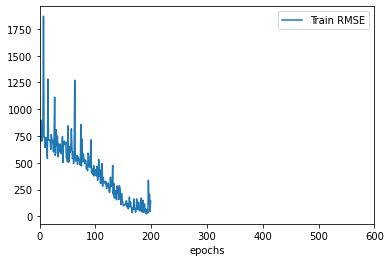

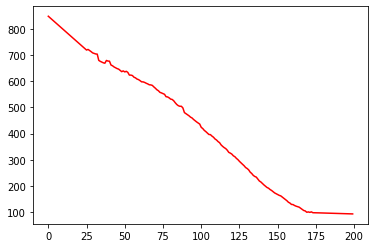

In [41]:
plt.plot(train_loss, label="Train RMSE")
plt.xlabel("epochs")
plt.xlim(0,600)
plt.legend()
plt.show()

from scipy.signal import savgol_filter
yhat = savgol_filter(train_loss, 51, 1) # window size 51, polynomial order 3
plt.plot(yhat, color='red')
plt.show()

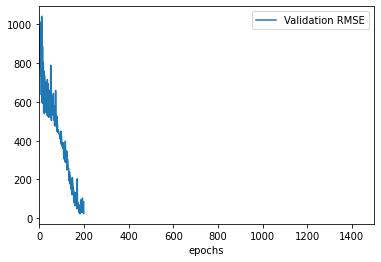

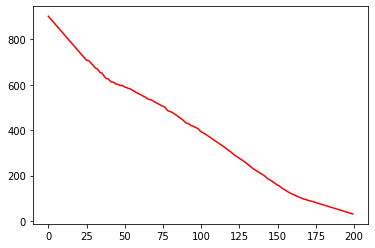

In [42]:
plt.plot(valid_loss, label="Validation RMSE")
plt.xlabel("epochs")
plt.xlim(0,1500)
plt.legend()
plt.show()

from scipy.signal import savgol_filter
yhat = savgol_filter(valid_loss, 51, 1) # window size 51, polynomial order 3
plt.plot(yhat, color='red')
plt.show()

# SAVE AND TEST MODEL

In [43]:
torch.save(model_PINN,'PINN.pkl')

In [44]:
"""
Test PIRNN model
"""
model_PINN = torch.load('PINN.pkl')
model_PINN.to(device)
print(model_PINN)

y_test_error = list()
total_batch_num = 8160 # change manually,if required. sample of test data
model_PINN.eval()
for id_batch, (x_batch, y_batch) in enumerate(dataloader_physics_test):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    NN_output = model_PINN(x_batch)
    MSE_loss= torch.mean((NN_output - y_batch)**2)
    y_test_error.append(MSE_loss.item())

print(f"mean error is {np.mean(y_test_error)}, std is {np.std(y_test_error)}") 

RNN(
  (rnn): LSTM(5, 64, batch_first=True)
  (rnn1): ModuleList(
    (0): LSTM(64, 128, batch_first=True)
  )
  (output_layer): Linear(in_features=128, out_features=3, bias=True)
)
mean error is 0.05092025734484196, std is 0.006078226491808891


# VISUALIZATION OF MODEL PERFORMANCE

In [45]:
RNN_predict = model_PINN(x_test)
RNN_predict = scaler_y.inverse_transform(RNN_predict.detach().numpy().reshape(-1,3)).reshape(-1,36, 3)
print(RNN_predict.shape)
Y_real = scaler_y.inverse_transform(y_test.reshape(-1,3)).reshape(-1,36, 3)

(2, 36, 3)


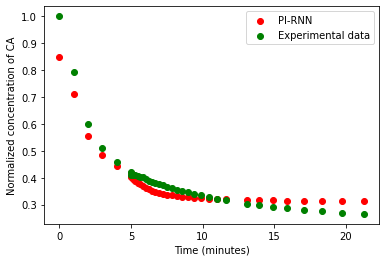

1.0523113098049806

In [46]:
#prediction performance of CA

j = -1
i = 0
Y_i = np.array(RNN_predict[j,:,i]).reshape(-1)
Y_real_i = np.array(Y_real[j,:,i]).reshape(-1)

plt.scatter(X1,Y_i, color='r')
plt.scatter(X1,Y_real_i, color='g')

plt.legend(['PI-RNN','Experimental data'])
plt.xlabel("Time (minutes)")
plt.ylabel("Normalized concentration of CA")
plt.show()

c = 0

for i in range(len(Y_i)):
    c += abs(Y_i[i] - Y_real_i[i]) 
c 

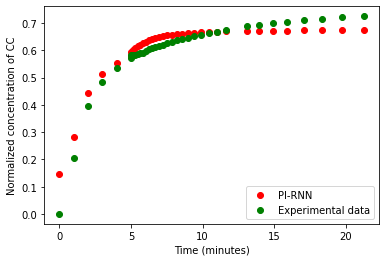

1.1030837273994278

In [47]:
#prediction performance of CC

j = -1
i = 1
Y_i = np.array(RNN_predict[j,:,i]).reshape(-1)
Y_real_i = np.array(Y_real[j,:,i]).reshape(-1)

plt.scatter(X1,Y_i, color='r')
plt.scatter(X1,Y_real_i, color='g')

plt.legend(['PI-RNN','Experimental data'])
plt.xlabel("Time (minutes)")
plt.ylabel("Normalized concentration of CC")
plt.show()

c = 0

for i in range(len(Y_i)):
    c += abs(Y_i[i] - Y_real_i[i]) 
c 

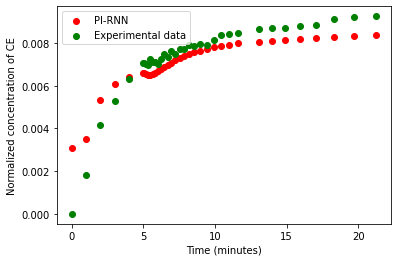

0.022566473960988927

In [48]:
#prediction performance of CE

j = -1
i = 2
Y_i = np.array(RNN_predict[j,:,i]).reshape(-1)
Y_real_i = np.array(Y_real[j,:,i]).reshape(-1)

plt.scatter(X1,Y_i, color='r')
plt.scatter(X1,Y_real_i, color='g')

plt.legend(['PI-RNN','Experimental data'])
plt.xlabel("Time (minutes)")
plt.ylabel("Normalized concentration of CE")
plt.show()

c = 0

for i in range(len(Y_i)):
    c += abs(Y_i[i] - Y_real_i[i]) 
c 